### Урок 6. Feature Engineering, Feature Selection, part II

### -- Автор: Шенк Евгений Станиславович

### Домашнее задание 6:
Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).  

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.  
Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.  
Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.  
Задание 3: использовать  
permutation importance  
, выполнить задание 1 и 2.  
Задание 4: использовать  
shap  
, выполнить задание 1 и 2.  
Задание 5: построить  
shap.summary_plot  
и  
shap.decision_plot  
для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.  

#### Выводы и результаты вконце нотбука

In [1]:
import numpy as np
import pandas as pd
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from typing import List, Tuple, Optional

from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, GroupShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

### Загрузка датасета

In [3]:
data = pd.read_csv("../data/data_total.csv")
lb_dataset = pd.read_csv("../data/lb_dataset_total.csv")

print("data.shape = {} rows, {} cols".format(*data.shape))
print("lb_dataset.shape = {} rows, {} cols".format(*lb_dataset.shape))

data.shape = 180000 rows, 453 cols
lb_dataset.shape = 100001 rows, 453 cols


In [4]:
data.sort_values(by='TransactionID', ascending=True, inplace=True)

In [5]:
data.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,...,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,year,month_of_year,day_of_week,hour_of_day,day_of_month,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,TRANSACTIONAMT_MEAN_BY_CARD1,TRANSACTIONAMT_STD_BY_CARD1,TRANSACTIONAMT_MEAN_BY_CARD2,TRANSACTIONAMT_STD_BY_CARD2,TRANSACTIONAMT_MEAN_BY_CARD3,TRANSACTIONAMT_STD_BY_CARD3,TRANSACTIONAMT_MEAN_BY_CARD4,TRANSACTIONAMT_STD_BY_CARD4,TRANSACTIONAMT_MEAN_BY_CARD5,TRANSACTIONAMT_STD_BY_CARD5,TRANSACTIONAMT_MEAN_BY_CARD6,TRANSACTIONAMT_STD_BY_CARD6,TRANSACTIONAMT_MEAN_BY_ADDR1,TRANSACTIONAMT_STD_BY_ADDR1,TRANSACTIONAMT_MEAN_BY_ADDR2,TRANSACTIONAMT_STD_BY_ADDR2,TRANSACTIONAMT_MEAN_BY_CARD_1_2,TRANSACTIONAMT_STD_BY_CARD_1_2,TRANSACTIONAMT_MEAN_BY_CARD_1_2_3_5,TRANSACTIONAMT_STD_BY_CARD_1_2_3_5,TRANSACTIONAMT_MEAN_BY_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_STD_BY_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_BY_CARD1,D15_STD_BY_CARD1,D15_MEAN_BY_CARD2,D15_STD_BY_CARD2,D15_MEAN_BY_CARD3,D15_STD_BY_CARD3,D15_MEAN_BY_CARD4,D15_STD_BY_CARD4,D15_MEAN_BY_CARD5,D15_STD_BY_CARD5,D15_MEAN_BY_CARD6,D15_STD_BY_CARD6,D15_MEAN_BY_ADDR1,D15_STD_BY_ADDR1,D15_MEAN_BY_ADDR2,D15_STD_BY_ADDR2,D15_MEAN_BY_CARD_1_2,D15_STD_BY_CARD_1_2,D15_MEAN_BY_CARD_1_2_3_5,D15_STD_BY_CARD_1_2_3_5,D15_MEAN_BY_CARD_1_2_3_5_ADDR_1_2,D15_STD_BY_CARD_1_2_3_5_ADDR_1_2,TransactionAmt_int,TransactionAmt_frc,TransactionAmt_log,P_emaildomain_name,P_emaildomain_region,R_emaildomain_name,R_emaildomain_region
0,2987000,0,2017-12-02 00:00:00,68.5,W,0.000061,0.014506,0.879722,0.013211,0.000272,0.317939,0.038156,0.876289,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [6]:
lb_dataset.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,...,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,year,month_of_year,day_of_week,hour_of_day,day_of_month,card_1_2,card_1_2_3_5,card_1_2_3_5_addr_1_2,TRANSACTIONAMT_MEAN_BY_CARD1,TRANSACTIONAMT_STD_BY_CARD1,TRANSACTIONAMT_MEAN_BY_CARD2,TRANSACTIONAMT_STD_BY_CARD2,TRANSACTIONAMT_MEAN_BY_CARD3,TRANSACTIONAMT_STD_BY_CARD3,TRANSACTIONAMT_MEAN_BY_CARD4,TRANSACTIONAMT_STD_BY_CARD4,TRANSACTIONAMT_MEAN_BY_CARD5,TRANSACTIONAMT_STD_BY_CARD5,TRANSACTIONAMT_MEAN_BY_CARD6,TRANSACTIONAMT_STD_BY_CARD6,TRANSACTIONAMT_MEAN_BY_ADDR1,TRANSACTIONAMT_STD_BY_ADDR1,TRANSACTIONAMT_MEAN_BY_ADDR2,TRANSACTIONAMT_STD_BY_ADDR2,TRANSACTIONAMT_MEAN_BY_CARD_1_2,TRANSACTIONAMT_STD_BY_CARD_1_2,TRANSACTIONAMT_MEAN_BY_CARD_1_2_3_5,TRANSACTIONAMT_STD_BY_CARD_1_2_3_5,TRANSACTIONAMT_MEAN_BY_CARD_1_2_3_5_ADDR_1_2,TRANSACTIONAMT_STD_BY_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_BY_CARD1,D15_STD_BY_CARD1,D15_MEAN_BY_CARD2,D15_STD_BY_CARD2,D15_MEAN_BY_CARD3,D15_STD_BY_CARD3,D15_MEAN_BY_CARD4,D15_STD_BY_CARD4,D15_MEAN_BY_CARD5,D15_STD_BY_CARD5,D15_MEAN_BY_CARD6,D15_STD_BY_CARD6,D15_MEAN_BY_ADDR1,D15_STD_BY_ADDR1,D15_MEAN_BY_ADDR2,D15_STD_BY_ADDR2,D15_MEAN_BY_CARD_1_2,D15_STD_BY_CARD_1_2,D15_MEAN_BY_CARD_1_2_3_5,D15_STD_BY_CARD_1_2_3_5,D15_MEAN_BY_CARD_1_2_3_5_ADDR_1_2,D15_STD_BY_CARD_1_2_3_5_ADDR_1_2,TransactionAmt_int,TransactionAmt_frc,TransactionAmt_log,P_emaildomain_name,P_emaildomain_region,R_emaildomain_name,R_emaildomain_region
0,3287000,1,2018-02-24 19:43:58,226.0,W,0.000006,0.069933,0.879722,0.657194,0.511961,0.317939,0.087100,0.876289,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,3.0,T,T,F,M0,T,F,F,F,T,1.0,2.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,7.0,0.0,1.0,1.0,2.0,6.0,6.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,452.0,1482.0,1482.0,0.0,206.0,206.0,452.0,1276.0,1276.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
numerical_features = data.drop(['isFraud'], axis=1).select_dtypes(include=[np.number]).columns
categorical_features = data.select_dtypes(include=[np.object]).columns

In [8]:
params = {
    "eval_metric": "auc",
    "verbose": 50,
    "early_stopping_rounds": 25,
}

In [9]:
def do_train_test_split(data: pd.DataFrame, numerical_features: list):
    x_train, x_valid = train_test_split(
        data.drop(['isFraud'], axis=1), train_size=0.6, shuffle=False,
    )
    y_train, y_valid = train_test_split(
        data["isFraud"], train_size=0.6, shuffle=False,
    )

    x_train = x_train[numerical_features]
    x_valid = x_valid[numerical_features]

    x_valid, x_test = train_test_split(
        x_valid, train_size=0.6, shuffle=False,
    )
    y_valid, y_test = train_test_split(
        y_valid, train_size=0.6, shuffle=False,
    )

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
    print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [10]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          params: dict,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.
        
    paprams: dict
        Параметры модели

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

        estimator.fit(x_train, y_train, 
                      eval_set=(x_valid, y_valid),
                      **params)
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]

        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [11]:
def calc_val_results(estimator: object):
    train_score = roc_auc_score(y_train, estimator.predict_proba(x_train)[:,1])
    print(f'Train roc_auc_score: {train_score}')
    valid_score = roc_auc_score(y_valid, estimator.predict_proba(x_valid)[:,1])
    print(f'Valid roc_auc_score: {valid_score}')
    test_score = roc_auc_score(y_test, estimator.predict_proba(x_test)[:,1])
    print(f'Test roc_auc_score:  {test_score}')
    lb_score = roc_auc_score(lb_dataset['isFraud'], estimator.predict_proba(lb_dataset_prep)[:,1])
    print(f'LB roc_auc_score:    {lb_score}')
    return(train_score, valid_score, test_score, lb_score)

### Задание 0. Валидация

In [12]:
data.sort_values(by='TransactionDT', ascending=True, inplace=True)

In [13]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, numerical_features)

x_train.shape = 108000 rows, 439 cols
x_valid.shape = 43200 rows, 439 cols
x_test.shape = 28800 rows, 439 cols


In [14]:
x_train = x_train.drop(['TransactionID'], axis=1)
total_features = x_train.columns

x_valid = x_valid[total_features]
x_test = x_test[total_features]

In [15]:
model_lgb_1 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)
### Model for CV
model_1 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [16]:
model_lgb_1.fit(x_train, y_train, 
                eval_set=(x_valid, y_valid),
                **params)

Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.874624	valid_0's binary_logloss: 0.0898633
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.87808	valid_0's binary_logloss: 0.0885523


LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [17]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train, y_train, model_1, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.724767	valid_0's binary_logloss: 0.10656
Fold: 1, train-observations = 86400, valid-observations = 21600
train-score = 0.7828, valid-score = 0.7248
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[18]	valid_0's auc: 0.853615	valid_0's binary_logloss: 0.0873042
Fold: 2, train-observations = 86400, valid-observations = 21600
train-score = 0.8655, valid-score = 0.8536
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.888055	valid_0's binary_logloss: 0.0769151
Did not meet early stopping. Best iteration is:
[50]	valid_0's auc: 0.888055	valid_0's binary_logloss: 0.0769151
Fold: 3, train-observations = 86400, valid-observations = 21600
train-score = 0.8899, valid-score = 0.8881
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.887445	valid_0's binary_logloss: 0.075

In [18]:
print(f'{np.mean(fold_valid_scores) - np.std(fold_valid_scores)}, {np.mean(fold_valid_scores) + np.std(fold_valid_scores)}')

0.7822538844059612, 0.903976831296428


In [19]:
lb_dataset_prep = lb_dataset.copy()
lb_dataset_prep = lb_dataset_prep[total_features]

In [20]:
task_1_results = calc_val_results(model_lgb_1)

Train roc_auc_score: 0.8988083654357675
Valid roc_auc_score: 0.8780800241955569
Test roc_auc_score:  0.8627379003560303
LB roc_auc_score:    0.8599832478254212


### Задание 1: внутренний способ для оценки важности признаков алгоритма

In [21]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)

    plt.figure(figsize=(20, len(feature_importances) * 0.355))

    sns.barplot(feature_importances['importance'], feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

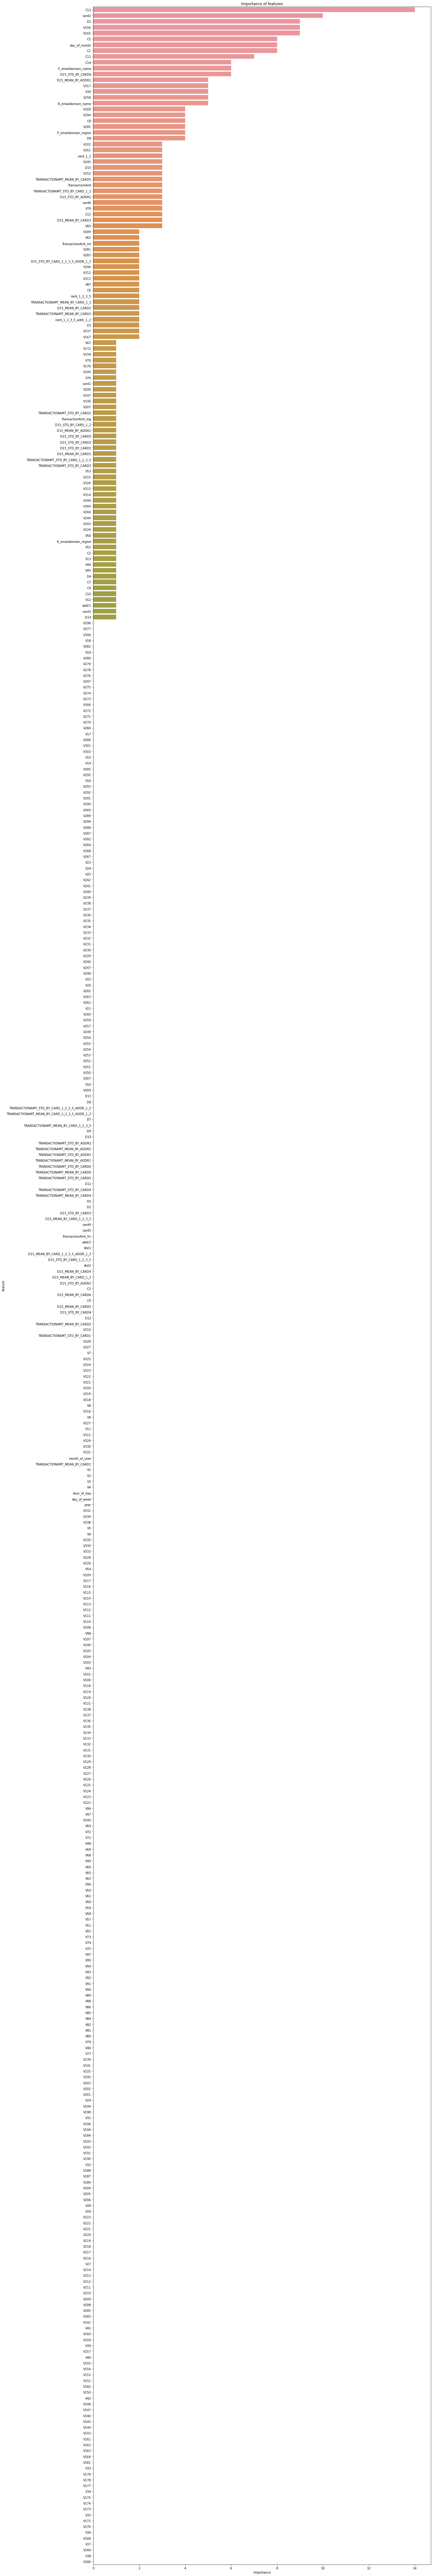

In [22]:
top_feat = show_feature_importances(total_features, model_lgb_1.feature_importances_, get_top=57)

### Задание 2: удалить признаки с нулевой или маленькой важностью

In [23]:
len(top_feat)

57

In [24]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, top_feat)

x_train.shape = 108000 rows, 57 cols
x_valid.shape = 43200 rows, 57 cols
x_test.shape = 28800 rows, 57 cols


In [25]:
model_lgb_2 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)
### Model for CV
model_2 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [26]:
model_lgb_2.fit(x_train, y_train, 
                eval_set=(x_valid, y_valid),
                **params)

Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.875246	valid_0's binary_logloss: 0.0911744
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.878282	valid_0's binary_logloss: 0.0893701


LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [27]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train, y_train, model_2, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.545209	valid_0's binary_logloss: 0.111579
Fold: 1, train-observations = 86400, valid-observations = 21600
train-score = 0.6102, valid-score = 0.5452
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[21]	valid_0's auc: 0.859576	valid_0's binary_logloss: 0.0862768
Fold: 2, train-observations = 86400, valid-observations = 21600
train-score = 0.8709, valid-score = 0.8596
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.888716	valid_0's binary_logloss: 0.0767222
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.893575	valid_0's binary_logloss: 0.0757976
Fold: 3, train-observations = 86400, valid-observations = 21600
train-score = 0.8949, valid-score = 0.8936
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.886606	valid_0's binary_logloss: 0.07

In [28]:
print(f'{np.mean(fold_valid_scores) - np.std(fold_valid_scores)}, {np.mean(fold_valid_scores) + np.std(fold_valid_scores)}')

0.6765452516709329, 0.9425356213743341


In [29]:
lb_dataset_prep = lb_dataset.copy()
lb_dataset_prep = lb_dataset_prep[top_feat]

In [30]:
task_2_results = calc_val_results(model_lgb_2)

Train roc_auc_score: 0.8982972758591149
Valid roc_auc_score: 0.8782816477805127
Test roc_auc_score:  0.8619706991464502
LB roc_auc_score:    0.8609658501563131


### Задание 3: permutation importance

In [31]:
from sklearn.inspection import permutation_importance

In [32]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, total_features)

x_train.shape = 108000 rows, 438 cols
x_valid.shape = 43200 rows, 438 cols
x_test.shape = 28800 rows, 438 cols


In [33]:
%%time
importance_1 = permutation_importance(
    model_lgb_1, x_valid, y_valid, scoring="roc_auc", n_jobs=-1, random_state=2177)

Wall time: 3min 20s


In [34]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance_1.importances_mean,
    "importance-std": importance_1.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [35]:
importance_scores

,features,importance-mean,importance-std
0,C14,0.011154,0.000878
1,D15_STD_BY_CARD6,0.004521,0.000768
2,C5,0.004409,0.001126
3,C8,0.004053,0.000431
4,V156,0.003945,0.000948
...,...,...,...
433,V102,-0.000242,0.000334
434,V315,-0.000274,0.000098
435,V224,-0.000369,0.000007
436,V285,-0.000564,0.000090


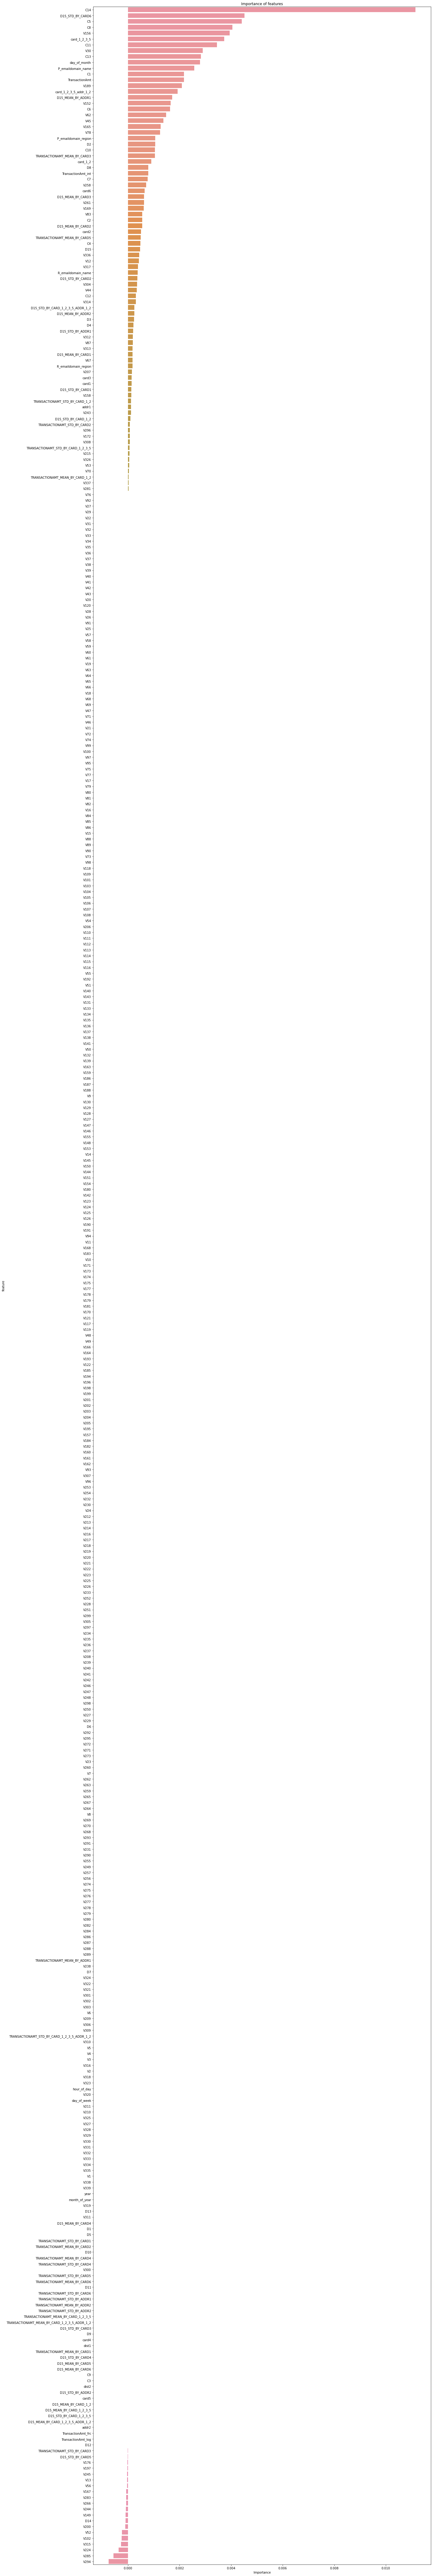

In [36]:
_ = show_feature_importances(importance_scores['features'].tolist(), importance_scores['importance-mean'].tolist(), get_top=100)

In [37]:
top_feat_3 = importance_scores[importance_scores['importance-mean'] > 0.0001].features.tolist()

In [38]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, top_feat_3)

x_train.shape = 108000 rows, 70 cols
x_valid.shape = 43200 rows, 70 cols
x_test.shape = 28800 rows, 70 cols


In [39]:
model_lgb_3 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)
### Model for CV
model_3 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [40]:
model_lgb_3.fit(x_train, y_train, 
                eval_set=(x_valid, y_valid),
                **params)

Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.874297	valid_0's binary_logloss: 0.0897669
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.87859	valid_0's binary_logloss: 0.0876207


LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [41]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train, y_train, model_3, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.724976	valid_0's binary_logloss: 0.106434
Fold: 1, train-observations = 86400, valid-observations = 21600
train-score = 0.7829, valid-score = 0.725
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[20]	valid_0's auc: 0.860387	valid_0's binary_logloss: 0.0867895
Fold: 2, train-observations = 86400, valid-observations = 21600
train-score = 0.8689, valid-score = 0.8604
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.89035	valid_0's binary_logloss: 0.0766774
Did not meet early stopping. Best iteration is:
[70]	valid_0's auc: 0.895078	valid_0's binary_logloss: 0.0755335
Fold: 3, train-observations = 86400, valid-observations = 21600
train-score = 0.8972, valid-score = 0.8951
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.885869	valid_0's binary_logloss: 0.0742

In [42]:
print(f'{np.mean(fold_valid_scores) - np.std(fold_valid_scores)}, {np.mean(fold_valid_scores) + np.std(fold_valid_scores)}')

0.784204671706431, 0.908996658338145


In [43]:
lb_dataset_prep = lb_dataset.copy()
lb_dataset_prep = lb_dataset_prep[top_feat_3]

In [44]:
task_3_results = calc_val_results(model_lgb_3)

Train roc_auc_score: 0.896176863796141
Valid roc_auc_score: 0.8785904332924817
Test roc_auc_score:  0.8638299334967335
LB roc_auc_score:    0.8581904925822182


### Задание 4: shap

In [45]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, total_features)

x_train.shape = 108000 rows, 438 cols
x_valid.shape = 43200 rows, 438 cols
x_test.shape = 28800 rows, 438 cols


In [46]:
%%time
explainer = shap.TreeExplainer(model_lgb_1)
shap_values = explainer.shap_values(x_valid, y_valid)

Wall time: 637 ms


In [47]:
shap.initjs()
example=2
shap.force_plot(
    explainer.expected_value[0], shap_values[0][example], x_valid.iloc[0,:], link="logit"
)

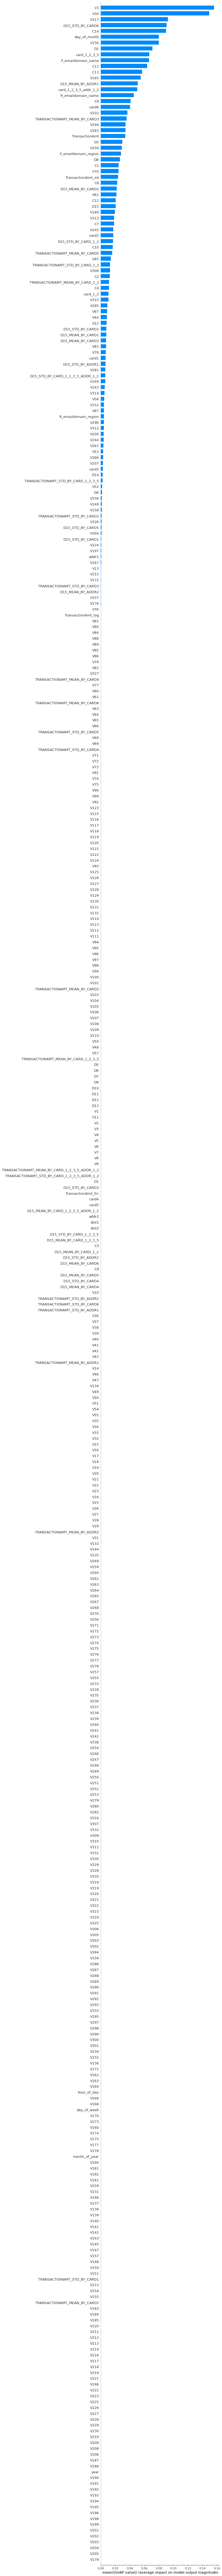

In [48]:
shap.summary_plot(shap_values[0], x_valid, plot_type="bar", max_display=x_valid.shape[1])

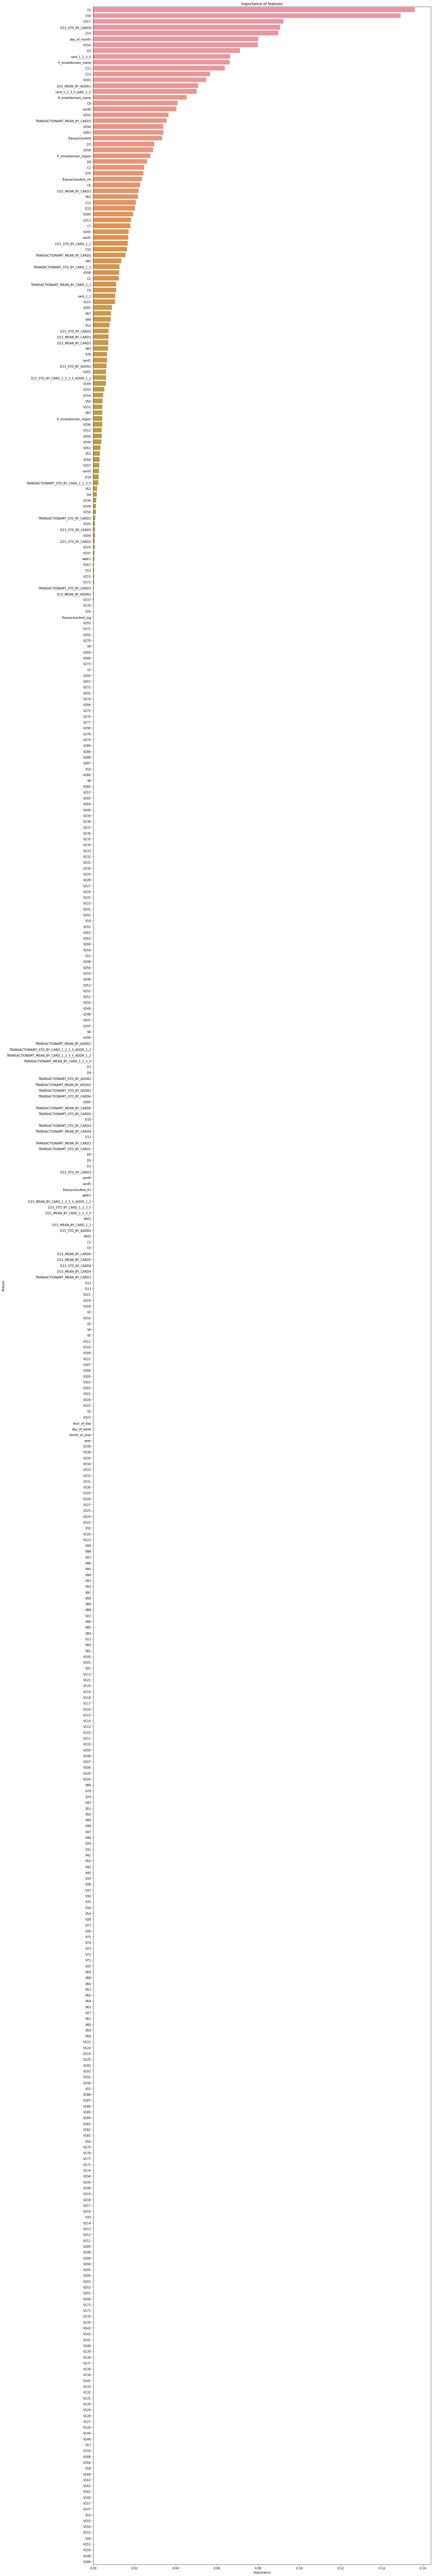

In [49]:
_ = show_feature_importances(total_features, np.abs(shap_values[0]).mean(axis=0), get_top=100)

In [50]:
top_feat_4 = total_features[np.abs(shap_values[0]).mean(axis=0) > 0.005].tolist()

In [51]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, top_feat_4 )

x_train.shape = 108000 rows, 66 cols
x_valid.shape = 43200 rows, 66 cols
x_test.shape = 28800 rows, 66 cols


In [52]:
model_lgb_4 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)
### Model for CV
model_4 = lgb.LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [53]:
model_lgb_4.fit(x_train, y_train, 
                eval_set=(x_valid, y_valid),
                **params)

Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.872426	valid_0's binary_logloss: 0.0902845
Did not meet early stopping. Best iteration is:
[69]	valid_0's auc: 0.875863	valid_0's binary_logloss: 0.0886498


LGBMClassifier(n_estimators=70, num_leaves=5, seed=2177)

In [54]:
cv_strategy = StratifiedKFold(n_splits=5, random_state=2177)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
    x_train, y_train, model_4, params, metric=roc_auc_score, cv_strategy=cv_strategy
)

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[3]	valid_0's auc: 0.724655	valid_0's binary_logloss: 0.106533
Fold: 1, train-observations = 86400, valid-observations = 21600
train-score = 0.7831, valid-score = 0.7247
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[22]	valid_0's auc: 0.860278	valid_0's binary_logloss: 0.0852958
Fold: 2, train-observations = 86400, valid-observations = 21600
train-score = 0.871, valid-score = 0.8603
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.888343	valid_0's binary_logloss: 0.0771654
Did not meet early stopping. Best iteration is:
[59]	valid_0's auc: 0.891232	valid_0's binary_logloss: 0.076693
Fold: 3, train-observations = 86400, valid-observations = 21600
train-score = 0.8916, valid-score = 0.8912
Training until validation scores don't improve for 25 rounds
[50]	valid_0's auc: 0.886454	valid_0's binary_logloss: 0.0745

In [55]:
print(f'{np.mean(fold_valid_scores) - np.std(fold_valid_scores)}, {np.mean(fold_valid_scores) + np.std(fold_valid_scores)}')

0.7838574231182652, 0.9079553678270184


In [56]:
lb_dataset_prep = lb_dataset.copy()
lb_dataset_prep = lb_dataset_prep[top_feat_4]

In [57]:
task_4_results = calc_val_results(model_lgb_4)

Train roc_auc_score: 0.8956445440025009
Valid roc_auc_score: 0.8758634366048718
Test roc_auc_score:  0.8613999441411698
LB roc_auc_score:    0.8568744853093317


### Задание 5

In [58]:
x_train, x_valid, x_test, y_train, y_valid, y_test = do_train_test_split(data, total_features)

x_train.shape = 108000 rows, 438 cols
x_valid.shape = 43200 rows, 438 cols
x_test.shape = 28800 rows, 438 cols


In [59]:
x_valid_, y_valid_ = x_valid.sample(200), y_valid.sample(200)

explainer = shap.TreeExplainer(model_lgb_1)
shap_values = explainer.shap_values(x_valid_, y_valid_)

expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
    
select = range(20)
features = x_valid.iloc[select]
features_display = x_valid.loc[features.index]

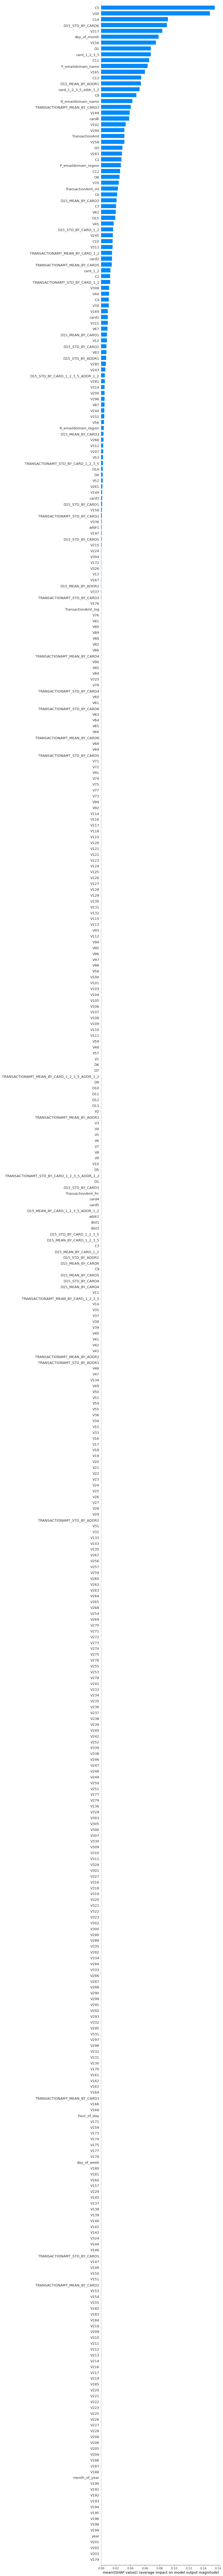

In [60]:
shap.summary_plot(shap_values[0], x_valid_, plot_type="bar", max_display=x_valid.shape[1])

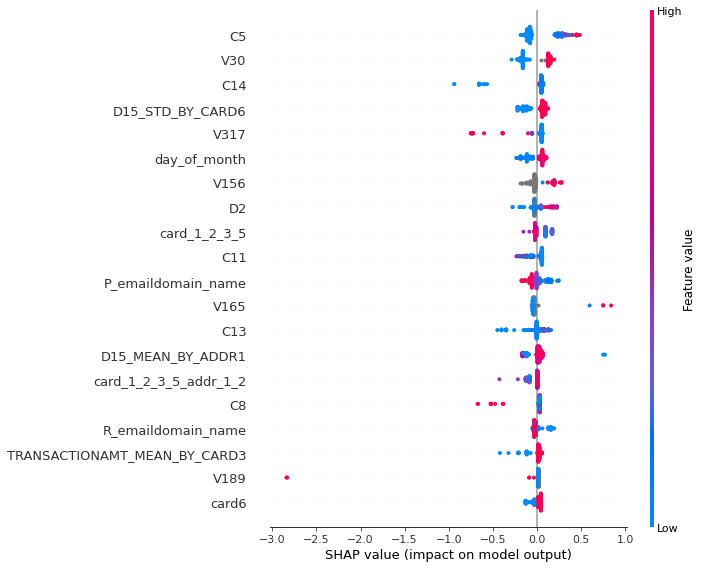

In [61]:
shap.summary_plot(shap_values[0], x_valid_)

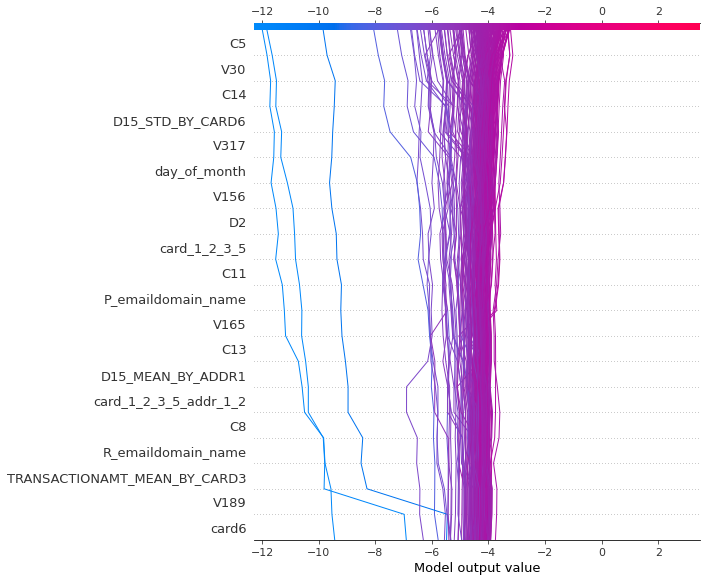

In [62]:
shap.decision_plot(
    expected_value, shap_values[0], features_display.iloc[:20]
)

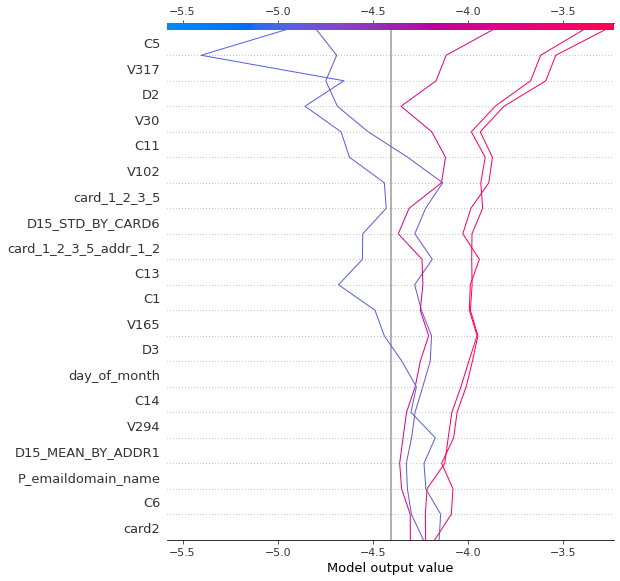

In [63]:
# Неверно классифицированные наблюдения
shap_values = explainer.shap_values(x_valid_, y_valid_)
y_pred = (shap_values[0].sum(1) + expected_value) > 0

misclassified = y_pred != y_valid_
shap.decision_plot(
    expected_value, shap_values[0][misclassified[:1000]], features_display.iloc[:20]
)

# Результаты

In [64]:
Global_results_1 = pd.DataFrame({'Base': task_1_results,
                                'Inner': task_2_results,
                                'Permut': task_3_results,
                                'Shap': task_4_results,},
                                index=['Train_AUC', 'Valid_AUC', 'Test_AUC', 'LB_AUC'])

In [65]:
Global_results_1

,Base,Inner,Permut,Shap
Train_AUC,0.898808,0.898297,0.896177,0.895645
Valid_AUC,0.878080,0.878282,0.878590,0.875863
Test_AUC,0.862738,0.861971,0.863830,0.861400
LB_AUC,0.859983,0.860966,0.858190,0.856874


### Выводы:
Задания выполнены. Но для нашей модели удаление неважных фичей на результат практически не повлияло (доверительный интервал +/- 0.062). На полученых графиках shap видим влияние признаков, сильнее всего влияют C5 и V30.